<a href="https://colab.research.google.com/github/sokrypton/ColabDesign/blob/main/af/examples/AF2Rank.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#AF2Rank
[AF2Rank](https://github.com/jproney/AF2Rank) implemented using ColabDesign. 

If you find useful, please cite:
- Roney, J.P. and Ovchinnikov, S., 2022. **State-of-the-Art estimation of protein model accuracy using AlphaFold**. [BioRxiv](https://www.biorxiv.org/content/10.1101/2022.03.11.484043v3.full).

In [1]:
#@title ## Setup
%%bash
if [ ! -d params ]; then
  # get code
  pip -q install git+https://github.com/sokrypton/ColabDesign.git
  # for debugging
  ln -s /usr/local/lib/python3.7/dist-packages/colabdesign colabdesign

  # alphafold params
  mkdir params
  curl -fsSL https://storage.googleapis.com/alphafold/alphafold_params_2021-07-14.tar | tar x -C params

  # download openfold weights (optional)
  for W in openfold_model_ptm_1 openfold_model_ptm_2
  do wget -qnc https://files.ipd.uw.edu/krypton/openfold/${W}.npz -P params; done

  wget -qnc https://zhanggroup.org/TM-score/TMscore.cpp
  g++ -static -O3 -ffast-math -lm -o TMscore TMscore.cpp
fi

In [42]:
#@title import libraries
from colabdesign import clear_mem, mk_af_model
from colabdesign.shared.utils import copy_dict

import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
import jax

def tmscore(x,y):
  # save to dumpy pdb files
  for n,z in enumerate([x,y]): 
    out = open(f"{n}.pdb","w")
    for k,c in enumerate(z):
      out.write("ATOM  %5d  %-2s  %3s %s%4d    %8.3f%8.3f%8.3f  %4.2f  %4.2f\n" 
                  % (k+1,"CA","ALA","A",k+1,c[0],c[1],c[2],1,0))
    out.close()
  # pass to TMscore
  output = os.popen('./TMscore 0.pdb 1.pdb')
  # parse outputs
  parse_float = lambda x: float(x.split("=")[1].split()[0])
  o = {}
  for line in output:
    line = line.rstrip()
    if line.startswith("RMSD"): o["rms"] = parse_float(line)
    if line.startswith("TM-score"): o["tms"] = parse_float(line)
    if line.startswith("GDT-TS-score"): o["gdt"] = parse_float(line)
  return o

def get_score(model, wt_batch=None):
  score = copy_dict(model.aux["log"])

  score["plddt"] = 1 - score["plddt"]
  score["pae"] = score["pae"] * 31.0
  score["rmsd_io"] = score.pop("rmsd",None)

  i_xyz = model._inputs["batch"]["all_atom_positions"][:,1]
  o_xyz = np.array(model.aux["atom_positions"][:,1])

  # TMscore to input/output
  if wt_batch is not None:
    n_xyz = wt_batch["all_atom_positions"][:,1]
    score["tm_i"] = tmscore(n_xyz,i_xyz)["tms"]
    score["tm_o"] = tmscore(n_xyz,o_xyz)["tms"]

  # TMscore between input and output
  score["tm_io"] = tmscore(i_xyz,o_xyz)["tms"]

  # composite score
  score["composite"] = score["ptm"] * score["plddt"] * score["tm_io"]
  return score
  
def plot_me(scores, x="tm_i", y="composite", 
            title=None, diag=False, scale_axis=True, dpi=100):
  def rescale(a,amin=None,amax=None):  
    a = np.copy(a)
    if amin is None: amin = a.min()
    if amax is None: amax = a.max()
    a[a < amin] = amin
    a[a > amax] = amax
    return (a - amin)/(amax - amin)

  plt.figure(figsize=(5,5), dpi=dpi)
  if title is not None: plt.title(title)
  x_vals = np.array([k[x] for k in scores])
  y_vals = np.array([k[y] for k in scores])
  c = rescale(np.array([k["plddt"] for k in scores]),0.5,0.9)
  plt.scatter(x_vals, y_vals, c=c*0.75, s=5, vmin=0, vmax=1, cmap="gist_rainbow")
  if diag:
    plt.plot([0,1],[0,1],color="black")

  #plt.xticks([]); plt.yticks([])
  
  labels = {"tm_i":"TMscore of Input",
            "tm_o":"TMscore of Ouput",
            "tm_io":"TMscore between Input and Output",
            "ptm":"Predicted TMscore (pTM)",
            "plddt":"Predicted LDDT (pLDDT)",
            "composite":"Composite"}

  plt.xlabel(labels.get(x,x));  plt.ylabel(labels.get(y,y))
  if scale_axis:
    if x in labels: plt.xlim(-0.1, 1.1)
    if y in labels: plt.ylim(-0.1, 1.1)
  
  plt.show()
  print(spearmanr(x_vals,y_vals).correlation)

## rank structures

In [3]:
NAME = "1mjc"
CHAIN = "A" # this can be multiple chains
NATIVE_PATH = f"{NAME}.pdb"
DECOY_DIR = f"{NAME}"

# get data
%shell wget -qnc https://files.ipd.uw.edu/pub/decoyset/natives/{NAME}.pdb
%shell wget -qnc https://files.ipd.uw.edu/pub/decoyset/decoys/{NAME}.zip
%shell unzip -qqo {NAME}.zip

# setup model
clear_mem()
model = mk_af_model(protocol="fixbb", use_templates=True,
                    use_alphafold=True, use_openfold=True)
model.prep_inputs(NATIVE_PATH, chain=CHAIN)
model.set_seq(mode="wildtype")

# save wildtype inputs for computing true TMscore
WT_BATCH = copy_dict(model._inputs["batch"])

In [6]:
#@markdown ### Settings
seq_relacement = "gap" #@param ["gap", "X", "A", "none"]
mask_sidechains = True #@param {type:"boolean"}
recycles = 1 #@param ["0", "1", "2", "3", "4"] {type:"raw"}
iterations = 1 
model_name = "model_1_ptm" #@param ["model_1_ptm", "model_2_ptm", "openfold_model_ptm_1", "openfold_model_ptm_2"]
save_output_pdbs = False #@param {type:"boolean"}

tm_aa = -1
if seq_relacement == "A":   tm_aa = 0
if seq_relacement == "gap": tm_aa = 21
if seq_relacement == "X":   tm_aa = 20

ARGS = {"rm_tm_seq":seq_relacement != "none",
        "rm_tm_sc":not mask_sidechains,
        "recycles":int(recycles),
        "iterations":int(iterations),
        "model_name":model_name,        
        "tm_aatype":tm_aa, 
        "save_pdb":save_output_pdbs,
        "wt_batch":WT_BATCH,
        "chain":CHAIN}

def predict(pdb_path, chain="A", wt_batch=None, input_template=True, 
            rm_tm_seq=True, rm_tm_sc=True, recycles=1,
            iterations=1, model_name="model_1_ptm",
            tm_aatype=21, save_pdb=True, output_dir="tmp", verbose=True):
  
  model.prep_inputs(pdb_path, chain=chain)
  model.set_seq(mode="wildtype")

  model.set_opt(template=dict(dropout=not input_template, aatype=tm_aatype),
                rm_template_seq=rm_tm_seq, rm_template_sc=rm_tm_sc,
                num_recycles=recycles)
  
  # "manual" recycles using templates
  ini_atoms = model._inputs["batch"]["all_atom_positions"].copy()
  for i in range(iterations):
    model.predict(models=[model_name], verbose=False)
    if i < iterations - 1:
      model._inputs["batch"]["all_atom_positions"] = model.aux["atom_positions"]
    else:
      model._inputs["batch"]["all_atom_positions"] = ini_atoms
  
  if save_pdb:
    os.makedirs(output_dir, exist_ok=True)
    model.save_pdb(os.path.join(output_dir, os.path.basename(pdb_path)))

  score = get_score(model, wt_batch)
  score["id"] = pdb_path
  if verbose:
    print(*[f"{k} {score[k]:.4f}" for k in ["tm_i","tm_o","tm_io","composite","ptm","plddt"] if k in score], score["id"])
  return score

In [7]:
# score no structure
_ = predict(NATIVE_PATH, input_template=False, **ARGS)

tm_i 1.0000 tm_o 0.6650 tm_io 0.6650 composite 0.2399 ptm 0.5467 plddt 0.6599 1mjc.pdb


In [ ]:
SCORES = []

# score with structure
SCORES.append(predict(NATIVE_PATH, **ARGS))

# score the decoy sctructures
for decoy_pdb in os.listdir(DECOY_DIR):
  decoy_path = os.path.join(DECOY_DIR, decoy_pdb)
  SCORES.append(predict(decoy_path, **ARGS))

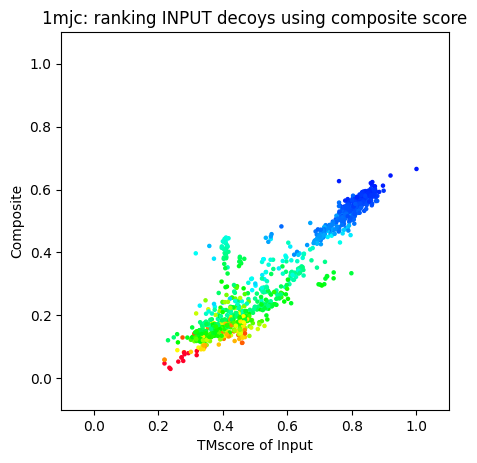

0.9286669238003632


In [27]:
plot_me(SCORES, x="tm_i", y="composite",
        title=f"{NAME}: ranking INPUT decoys using composite score")

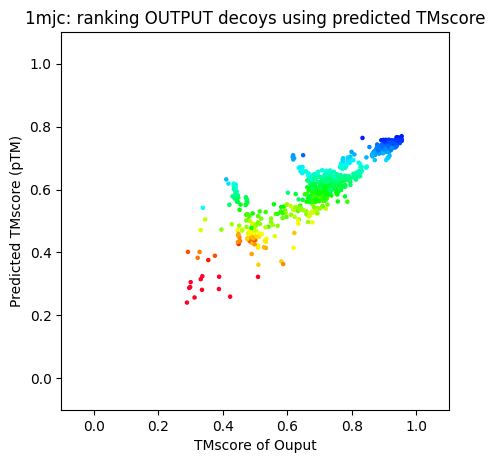

0.9142992958900363


In [28]:
plot_me(SCORES, x="tm_o", y="ptm",
        title=f"{NAME}: ranking OUTPUT decoys using predicted TMscore")

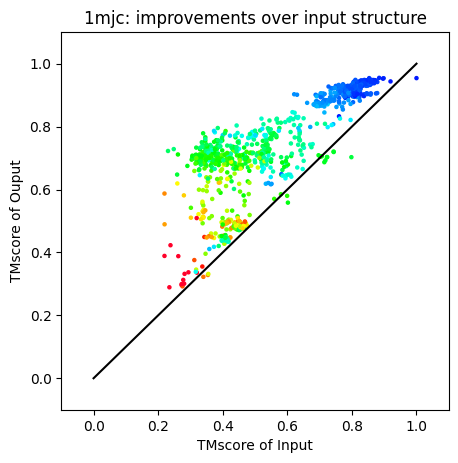

0.8287975642285275


In [29]:
plot_me(SCORES, x="tm_i", y="tm_o", diag=True,
        title=f"{NAME}: improvements over input structure")

## rank sequences
Example: ParD and ParE are an example of a toxin and antitoxin pair of proteins. If the pair of proteins bind, the organism survives, if they do not, organism does not! Mike Laub et al. created a library of mutants that targets this interface and their measured "fitness". Let's see how well AlphaFold can predict this, using the template trick.

In [30]:
# get data
%shell wget -qnc https://files.ipd.uw.edu/krypton/5CEG_AD_trim.pdb
%shell wget -qnc https://files.ipd.uw.edu/krypton/design/Library_fitness_vs_parE3_replicate_A.csv
%shell wget -qnc https://files.ipd.uw.edu/krypton/design/Library_fitness_vs_parE3_replicate_B.csv

lib_a = dict([line.rstrip().split(",") for line in open("Library_fitness_vs_parE3_replicate_A.csv")])
lib_b = dict([line.rstrip().split(",") for line in open("Library_fitness_vs_parE3_replicate_B.csv")])
lib_ab = jax.tree_map(lambda a,b:(float(a)+float(b))/2,lib_a,lib_b)

wt = "RHDDIRRLRQLWDEGKASGRPEPVDFDALRKEARQKLTE\
VRLVWSPTAKADLIDIYVMIGSENIRAADRYYDQLEARALQLADQPRMGVRRPDIRPSARMLVEAPFVLLYETVPDTDDGPVEWVEIVRVVDGRRDLNRLF"

In [31]:
clear_mem()
model = mk_af_model("fixbb",use_templates=True)
model.prep_inputs("5CEG_AD_trim.pdb", chain="A,B")
model.set_seq(mode="wildtype")
model.set_opt(num_recycles=1)

In [ ]:
SCORES = []

# lets parse the data
for mut,sco in lib_ab.items():

  # mutate seq
  seq = list(wt)
  for i,m in zip([10,11,12,15],list(mut)): seq[i] = m
  seq = "".join(seq)

  # predict
  model.predict(seq=seq, verbose=False)
  score = get_score(model)
  score.update({"fitness":sco,"mut":mut})
  print(*[f"{k} {score[k]:.4f}" for k in ["tm_io","rmsd_io","composite","ptm","plddt","fitness"]])  
  SCORES.append(score)

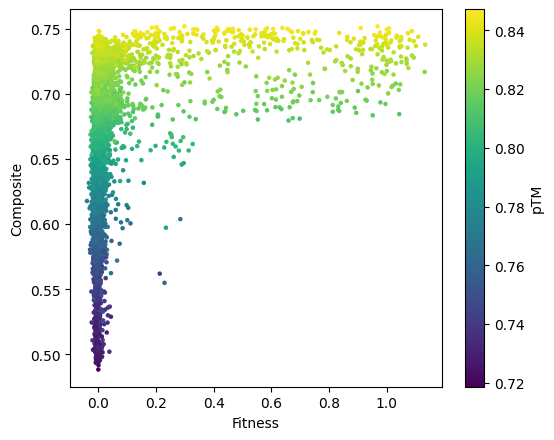

In [ ]:
plot_me(SCORES, x="fitness", y="composite", scale_axis=False)